In [ ]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [ ]:
!ls "/content/drive/MyDrive/Cs464/dataset"

test  train  train_aug


In [ ]:
import numpy as np
import cv2
import glob
import os
import matplotlib.pyplot as plt
import string
from mlxtend.plotting import plot_decision_regions
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.utils.multiclass import unique_labels
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import pandas as pd

In [ ]:
img_size = 48

In [ ]:
def getFaceImages(emotions, data_type, print_n=False):
    images = []
    labels = []
    path = "/content/drive/MyDrive/Cs464/dataset/" + data_type + "/"
    for i,f in enumerate(emotions):
        p = path + f
        j=0
        for image_path in glob.glob(os.path.join(p, "*.jpg")):
            image = cv2.imread(image_path, 0)
            image = cv2.resize(image, (img_size, img_size))
            images.append(image)
            labels.append(i)
            j+=1
        if(print_n):
            print("There are " , j , " " , data_type.upper(), " images of " , emotions[i].upper())
    images = np.array(images)
    labels = np.array(labels)
    return images, labels


# Train, Validation and Test Sets

In [ ]:
emotions = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

X, y =  getFaceImages(emotions, 'train', print_n=True)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

X_test, y_test = getFaceImages(emotions, 'test', print_n=True)

There are  3995   TRAIN  images of  ANGRY
There are  436   TRAIN  images of  DISGUST
There are  4097   TRAIN  images of  FEAR
There are  7221   TRAIN  images of  HAPPY
There are  4965   TRAIN  images of  NEUTRAL
There are  4830   TRAIN  images of  SAD
There are  3171   TRAIN  images of  SURPRISE
There are  958   TEST  images of  ANGRY
There are  111   TEST  images of  DISGUST
There are  1024   TEST  images of  FEAR
There are  1774   TEST  images of  HAPPY
There are  1239   TEST  images of  NEUTRAL
There are  1247   TEST  images of  SAD
There are  831   TEST  images of  SURPRISE


# Standard Scaler

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform([i.flatten() for i in X_train])
X_val = scaler.fit_transform([i.flatten() for i in X_val])
X_test = scaler.fit_transform([i.flatten() for i in X_test])

# Best Model

In [ ]:
classifier = RandomForestClassifier(n_estimators = 50, bootstrap=False, min_samples_split = 3, random_state = 42)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_val)
cm = confusion_matrix(y_val, y_pred)
print(cm)
print("Accuracy Score: ", accuracy_score(y_val, y_pred), "f1Score: ", f1_score(y_val, y_pred, average="weighted"))

[[ 178    0   60  268  118  131   23]
 [  13   23    7   24   12   11    2]
 [  64    0  234  264   91  121   61]
 [  61    0   40 1129  101  119   34]
 [  42    0   61  289  398  130   27]
 [  71    0   81  297  174  332   30]
 [  19    0   52  112   50   39  350]]
Accuracy Score:  0.4603865575483197 f1Score:  0.44265732370137617


# **OVERSAMPLING**

# Resample

In [ ]:
print("Class distribution before resampling:")
unique, counts = np.unique(y_train, return_counts=True)
print(dict(zip(unique, counts)))

Class distribution before resampling:
{0: 3217, 1: 344, 2: 3262, 3: 5737, 4: 4018, 5: 3845, 6: 2549}


In [ ]:
train_data = np.column_stack((X_train, y_train))

In [ ]:
upsampled_data = []

majority_class_label = unique[np.argmax(counts)]

for label in unique:
    if label != majority_class_label:
        minority_class = train_data[train_data[:, -1] == label]
        minority_upsampled = resample(minority_class, replace=True, n_samples=counts.max(), random_state=42)
        upsampled_data.append(minority_upsampled)

combined_data = np.vstack([train_data[train_data[:, -1] == majority_class_label]] + upsampled_data)

X_resampled = combined_data[:, :-1]
y_resampled = combined_data[:, -1]

print("\nClass distribution after resampling:")
unique, counts = np.unique(y_resampled, return_counts=True)
print(dict(zip(unique, counts)))



Class distribution after resampling:
{0.0: 5737, 1.0: 5737, 2.0: 5737, 3.0: 5737, 4.0: 5737, 5.0: 5737, 6.0: 5737}


In [ ]:
estimator_range = range(1, 252, 25)

weighted_f1_scores = []

for n_estimators in estimator_range:
    clf = RandomForestClassifier(n_estimators=n_estimators, random_state=42)
    clf.fit(X_resampled, y_resampled)

    y_pred = clf.predict(X_val)

    weighted_f1 = f1_score(y_val, y_pred, average='weighted')
    weighted_f1_scores.append(weighted_f1)

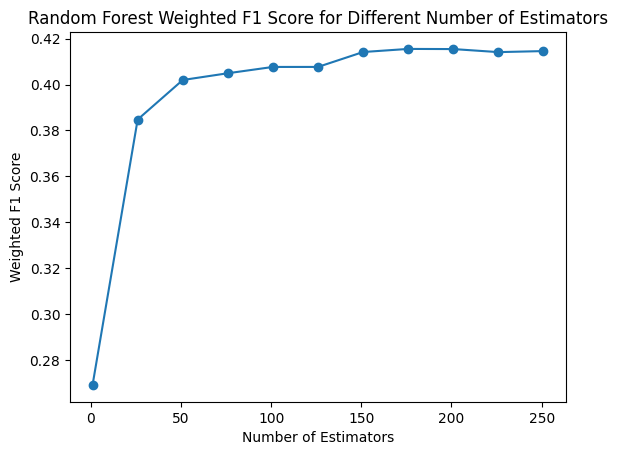

In [ ]:
plt.plot(estimator_range, weighted_f1_scores, marker='o')
plt.title('Random Forest Weighted F1 Score for Different Number of Estimators')
plt.xlabel('Number of Estimators')
plt.ylabel('Weighted F1 Score')
plt.show()

In [ ]:
sample_split_range = range(2, 6)

weighted_f1_scores = []

for sample_split in sample_split_range:
    clf = RandomForestClassifier(n_estimators=175, min_samples_split = sample_split, random_state=42)
    clf.fit(X_resampled, y_resampled)

    y_pred = clf.predict(X_val)

    weighted_f1 = f1_score(y_val, y_pred, average='weighted')
    weighted_f1_scores.append(weighted_f1)

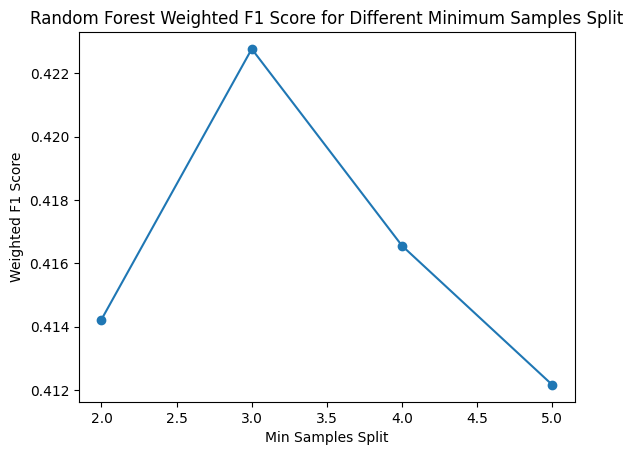

In [ ]:
plt.plot(sample_split_range, weighted_f1_scores, marker='o')
plt.title('Random Forest Weighted F1 Score for Different Minimum Samples Split')
plt.xlabel('Min Samples Split')
plt.ylabel('Weighted F1 Score')
plt.show()

In [ ]:
classifier = RandomForestClassifier(n_estimators = 175, min_samples_split = 3, random_state = 42)
classifier.fit(X_resampled, y_resampled)
y_pred = classifier.predict(X_val)
cm = confusion_matrix(y_val, y_pred)
print(cm)
print("Accuracy Score: ", accuracy_score(y_val, y_pred), "f1Score: ", f1_score(y_val, y_pred, average="weighted"))

[[ 151    0   46  398   68   80   35]
 [   4   28    5   40    6    4    5]
 [  41    0  196  349   50  118   81]
 [  34    0   19 1245   56   84   46]
 [  31    0   30  444  310   92   40]
 [  50    0   71  419  102  299   44]
 [  13    0   39  153   26   24  367]]
Accuracy Score:  0.45202855650356955 f1Score:  0.4227693321997305


# SMOTE

In [ ]:
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_SMOTE, y_SMOTE = smote.fit_resample(X_train, y_train)

print('Dataset shape %s' ,y_SMOTE.shape)

print('Resampled dataset shape %s' ,y_SMOTE.shape)


Dataset shape %s (40159,)
Resampled dataset shape %s (40159,)


In [ ]:
estimator_range = range(1, 302, 25)

for n_estimators in estimator_range:
    clf = RandomForestClassifier(n_estimators=n_estimators, random_state=42)
    clf.fit(X_SMOTE, y_SMOTE)

    y_pred = clf.predict(X_val)

    weighted_f1 = f1_score(y_val, y_pred, average='weighted')
    weighted_f1_scores.append(weighted_f1)

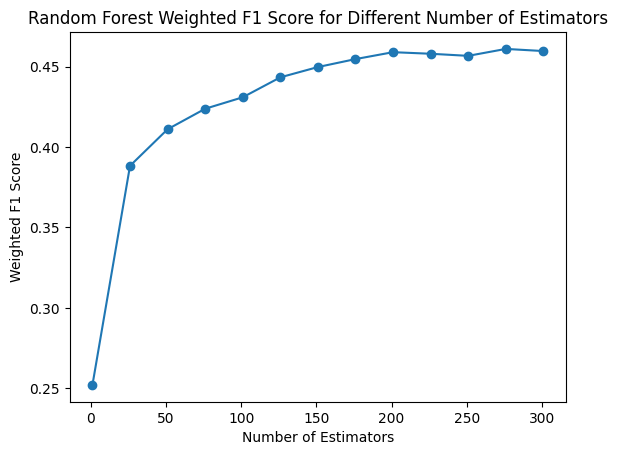

In [ ]:
plt.plot(estimator_range, weighted_f1_scores, marker='o')
plt.title('Random Forest Weighted F1 Score for Different Number of Estimators')
plt.xlabel('Number of Estimators')
plt.ylabel('Weighted F1 Score')
plt.show()

In [ ]:
sample_split_range = range(2, 6)

weighted_f1_scores = []

for sample_split in sample_split_range:
    clf = RandomForestClassifier(n_estimators=175, min_samples_split = sample_split, random_state=42)
    clf.fit(X_SMOTE, y_SMOTE)

    y_pred = clf.predict(X_val)

    weighted_f1 = f1_score(y_val, y_pred, average='weighted')
    weighted_f1_scores.append(weighted_f1)

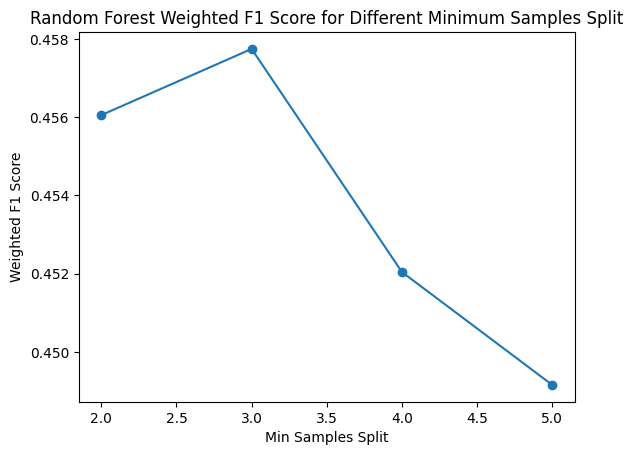

In [ ]:
plt.plot(sample_split_range, weighted_f1_scores, marker='o')
plt.title('Random Forest Weighted F1 Score for Different Minimum Samples Split')
plt.xlabel('Min Samples Split')
plt.ylabel('Weighted F1 Score')
plt.show()

In [ ]:
classifier = RandomForestClassifier(n_estimators = 175, min_samples_split = 3, random_state = 42)
classifier.fit(X_SMOTE, y_SMOTE)
y_pred = classifier.predict(X_val)
cm = confusion_matrix(y_val, y_pred)
print(cm)
print("Accuracy Score: ", accuracy_score(y_val, y_pred), "f1Score: ", f1_score(y_val, y_pred, average="weighted"))

[[237   2  80 172 103 144  40]
 [  4  39   7  15  11  11   5]
 [ 90   1 270 147  83 148  96]
 [101   3  80 927 139 159  75]
 [ 68   2  80 214 392 128  63]
 [ 90   4 119 174 147 398  53]
 [ 27   0  51  62  47  33 402]]
Accuracy Score:  0.4640431830053979 f1Score:  0.4577441747930133


# Balanced Bagging Classification

In [ ]:
classifier_BBC = RandomForestClassifier(n_estimators = 50, bootstrap=False, min_samples_split = 3, random_state = 42)
balanced_bagging_clf = BalancedBaggingClassifier(classifier_BBC,
                                                 n_estimators=50,
                                                 sampling_strategy='auto',  # 'auto' uses the inverse of class frequencies
                                                 random_state=42)
balanced_bagging_clf.fit(X_train, y_train)

BalancedBaggingClassifier(estimator=RandomForestClassifier(bootstrap=False,
                                                           min_samples_split=3,
                                                           n_estimators=50,
                                                           random_state=42),
                          n_estimators=50, random_state=42)

In [ ]:
y_pred = balanced_bagging_clf.predict(X_val)
cm = confusion_matrix(y_val, y_pred)
print(cm)
print("Accuracy Score: ", accuracy_score(y_val, y_pred), "f1Score: ", f1_score(y_val, y_pred, average="weighted"))

[[202   6  78 126 124 136 106]
 [  6  40   4  11  15   5  11]
 [ 80   8 214 101  89 153 190]
 [112  11  67 756 155 202 181]
 [ 65   6  85 142 376 142 131]
 [ 91  12 100 131 150 376 125]
 [ 30   3  41  42  51  27 428]]
Accuracy Score:  0.4165070520633815 f1Score:  0.4112743534869781


In [ ]:
classifier_BBC = RandomForestClassifier(n_estimators = 75, bootstrap=False, min_samples_split = 3, random_state = 42)
balanced_bagging_clf = BalancedBaggingClassifier(classifier_BBC,
                                                 n_estimators=50,
                                                 sampling_strategy='auto',  # 'auto' uses the inverse of class frequencies
                                                 random_state=42)
balanced_bagging_clf.fit(X_train, y_train)

BalancedBaggingClassifier(estimator=RandomForestClassifier(bootstrap=False,
                                                           min_samples_split=3,
                                                           n_estimators=75,
                                                           random_state=42),
                          n_estimators=50, random_state=42)

In [ ]:
y_pred = balanced_bagging_clf.predict(X_val)
cm = confusion_matrix(y_val, y_pred)
print(cm)
print("Accuracy Score: ", accuracy_score(y_val, y_pred), "f1Score: ", f1_score(y_val, y_pred, average="weighted"))

[[197   5  79 132 120 138 107]
 [  6  40   4  11  16   4  11]
 [ 77   9 210 106  85 157 191]
 [112   9  68 765 156 196 178]
 [ 66   8  84 137 369 150 133]
 [ 98  13 107 129 145 373 120]
 [ 31   3  38  44  48  29 429]]
Accuracy Score:  0.41493992686749087 f1Score:  0.40928761174337264


In [ ]:
classifier_BBC = RandomForestClassifier(n_estimators = 75, min_samples_split = 3, random_state = 42)
balanced_bagging_clf = BalancedBaggingClassifier(classifier_BBC,
                                                 n_estimators=50,
                                                 sampling_strategy='auto',  # 'auto' uses the inverse of class frequencies
                                                 random_state=42)
balanced_bagging_clf.fit(X_train, y_train)

BalancedBaggingClassifier(estimator=RandomForestClassifier(min_samples_split=3,
                                                           n_estimators=75,
                                                           random_state=42),
                          n_estimators=50, random_state=42)

In [ ]:
y_pred = balanced_bagging_clf.predict(X_val)
cm = confusion_matrix(y_val, y_pred)
print(cm)
print("Accuracy Score: ", accuracy_score(y_val, y_pred), "f1Score: ", f1_score(y_val, y_pred, average="weighted"))

[[196  10  78 121 121 135 117]
 [  1  41   5  13  12   8  12]
 [ 78  12 194  95  88 162 206]
 [106  19  78 717 163 211 190]
 [ 63  15  82 134 354 151 148]
 [ 96  18 111 116 148 366 130]
 [ 28   4  41  49  51  34 415]]
Accuracy Score:  0.3975274246909281 f1Score:  0.3930819714417762


# Random Over Sampler

In [ ]:
ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(X_train, y_train)

In [ ]:
print('Dataset shape %s' ,y_train.shape)

print('Resampled dataset shape %s' ,y_res.shape)

Dataset shape %s (22972,)
Resampled dataset shape %s (40159,)


In [ ]:
estimator_range = range(1, 252, 25)

weighted_f1_scores = []

for n_estimators in estimator_range:
    clf = RandomForestClassifier(n_estimators=n_estimators, random_state=42)
    clf.fit(X_res, y_res)

    y_pred = clf.predict(X_val)

    weighted_f1 = f1_score(y_val, y_pred, average='weighted')
    weighted_f1_scores.append(weighted_f1)

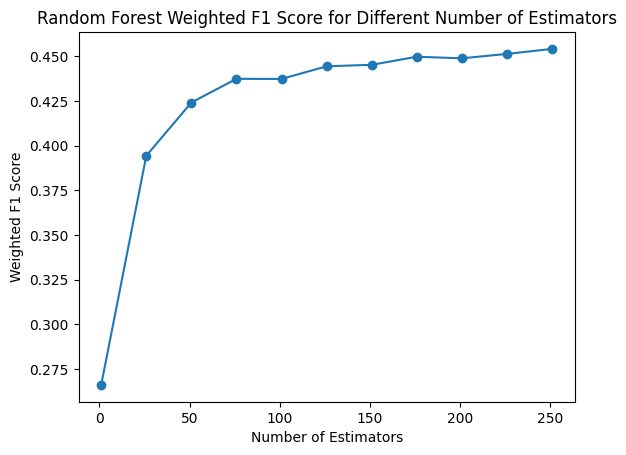

In [ ]:
plt.plot(estimator_range, weighted_f1_scores, marker='o')
plt.title('Random Forest Weighted F1 Score for Different Number of Estimators')
plt.xlabel('Number of Estimators')
plt.ylabel('Weighted F1 Score')
plt.show()

In [ ]:
sample_split_range = range(2, 6)

weighted_f1_scores = []

for sample_split in sample_split_range:
    clf = RandomForestClassifier(n_estimators=175, min_samples_split = sample_split, random_state=42)
    clf.fit(X_res, y_res)

    y_pred = clf.predict(X_val)

    weighted_f1 = f1_score(y_val, y_pred, average='weighted')
    weighted_f1_scores.append(weighted_f1)

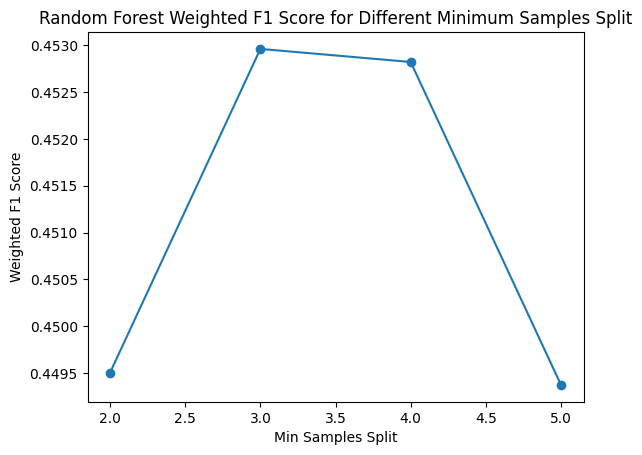

In [ ]:
plt.plot(sample_split_range, weighted_f1_scores, marker='o')
plt.title('Random Forest Weighted F1 Score for Different Minimum Samples Split')
plt.xlabel('Min Samples Split')
plt.ylabel('Weighted F1 Score')
plt.show()

In [ ]:
classifier = RandomForestClassifier(n_estimators = 175, min_samples_split = 3, random_state = 42)
classifier.fit(X_res, y_res)
y_pred = classifier.predict(X_val)
cm = confusion_matrix(y_val, y_pred)
print(cm)
print("Accuracy Score: ", accuracy_score(y_val, y_pred), "f1Score: ", f1_score(y_val, y_pred, average="weighted"))

[[ 182    0   58  262  106  144   26]
 [   7   29    5   25   11    7    8]
 [  53    0  250  240   83  133   76]
 [  52    0   44 1086  112  143   47]
 [  37    0   37  304  387  143   39]
 [  58    0   76  271  155  382   43]
 [  24    0   39  103   46   36  374]]
Accuracy Score:  0.46839630854953856 f1Score:  0.4529599109679927


# **Performances**

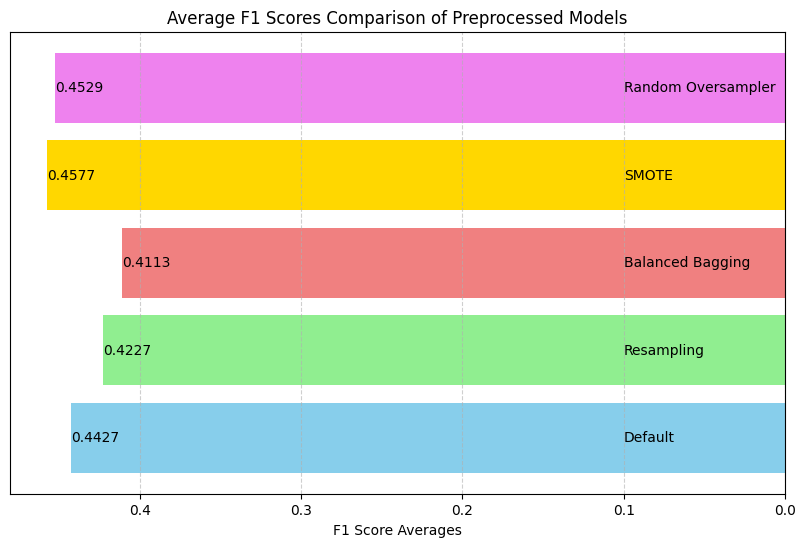

In [ ]:
models = ['Default', 'Resampling', 'Balanced Bagging', 'SMOTE', 'Random Oversampler']
f1scores = [0.4427, 0.4227, 0.4113, 0.4577, 0.4529]

fig, ax = plt.subplots(figsize=(10, 6))

colors = ['skyblue', 'lightgreen', 'lightcoral', 'gold', 'violet']

bars = ax.barh(models, f1scores, color=colors)

for bar, model in zip(bars, models):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, f'{bar.get_width():.4f}', ha='left',
             va='center', color='black', fontsize=10)
    plt.text(0.1, bar.get_y() + bar.get_height() / 2, model, ha='left', va='center', color='black', fontsize=10)

plt.xlabel('F1 Score Averages')
plt.title('Average F1 Scores Comparison of Preprocessed Models')

ax.yaxis.set_visible(False)

ax.xaxis.grid(True, linestyle='--', alpha=0.6)

ax.invert_xaxis()

plt.show()


In [ ]:
classifier_best = RandomForestClassifier(n_estimators = 175, min_samples_split = 3, random_state = 42)
classifier_best.fit(X_SMOTE, y_SMOTE)
y_pred_test = classifier_best.predict(X_test)
cm = confusion_matrix(y_test, y_pred_test)
print(cm)
print("Accuracy Score: ", accuracy_score(y_test, y_pred_test), "f1Score: ", f1_score(y_test, y_pred_test, average="weighted"))

[[ 267    1   99  226  125  174   66]
 [  13   47    7   21    9    9    5]
 [  96    0  331  180  132  154  131]
 [ 121    5  100 1092  181  189   86]
 [  99    3  113  241  498  211   74]
 [ 142    4  134  233  203  476   55]
 [  34    2   70   87   57   35  546]]
Accuracy Score:  0.4533685968819599 f1Score:  0.4466650708677029


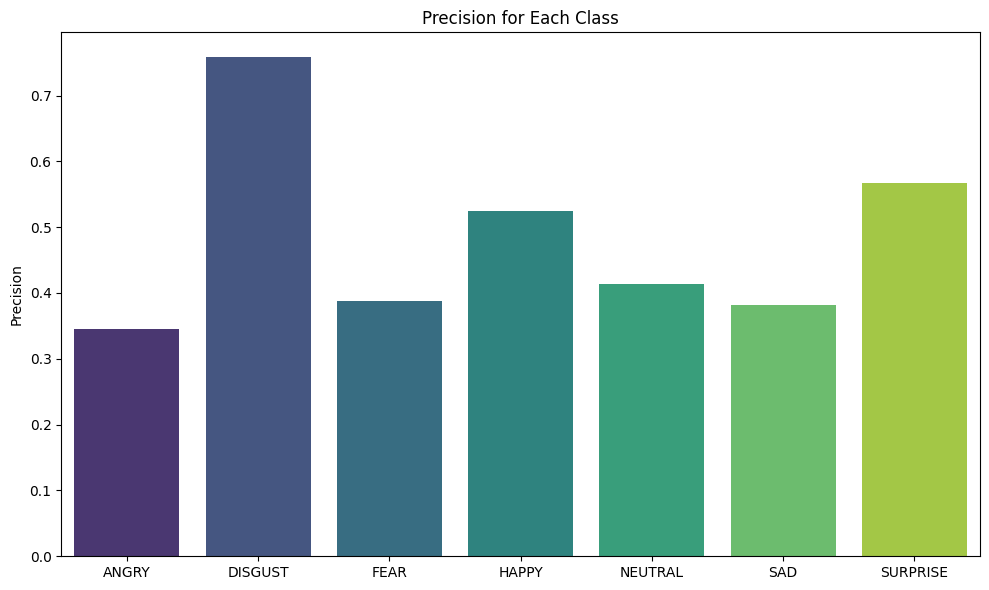

In [ ]:
class_labels = ['ANGRY', 'DISGUST', 'FEAR', 'HAPPY', 'NEUTRAL', 'SAD', 'SURPRISE']
report = classification_report(y_test, y_pred_test, target_names=class_labels, output_dict=True)

df = pd.DataFrame(report).transpose()

fig, axes = plt.subplots(figsize=(10, 6))
sns.barplot(x=class_labels, y=df.loc[class_labels, 'precision'], palette='viridis', ax=axes)
axes.set_title('Precision for Each Class')
axes.set_ylabel('Precision')
plt.tight_layout()
plt.show()

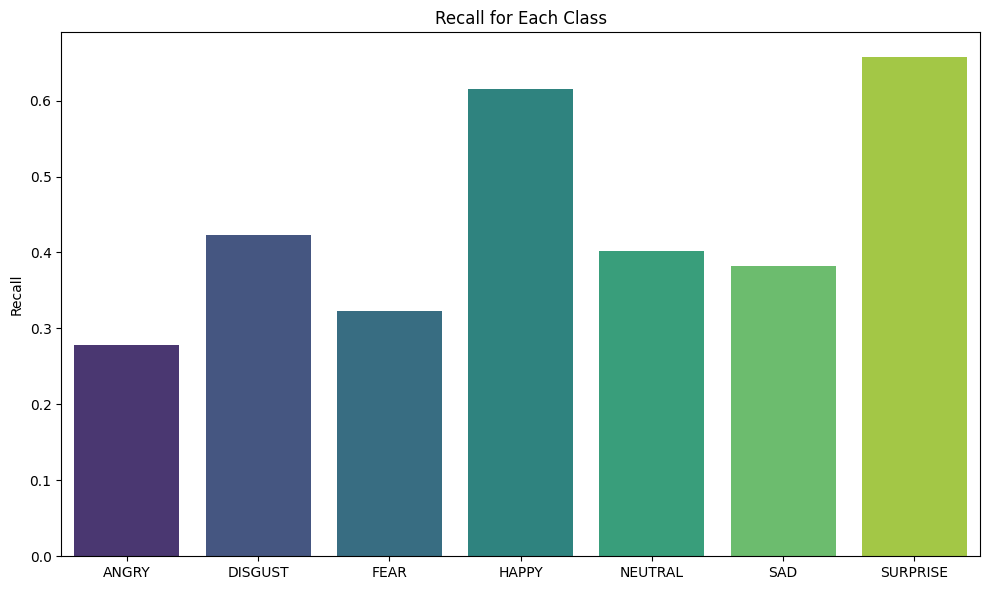

In [ ]:
fig, axes = plt.subplots(figsize=(10, 6))
sns.barplot(x=class_labels, y=df.loc[class_labels, 'recall'], palette='viridis', ax=axes)
axes.set_title('Recall for Each Class')
axes.set_ylabel('Recall')
plt.tight_layout()
plt.show()

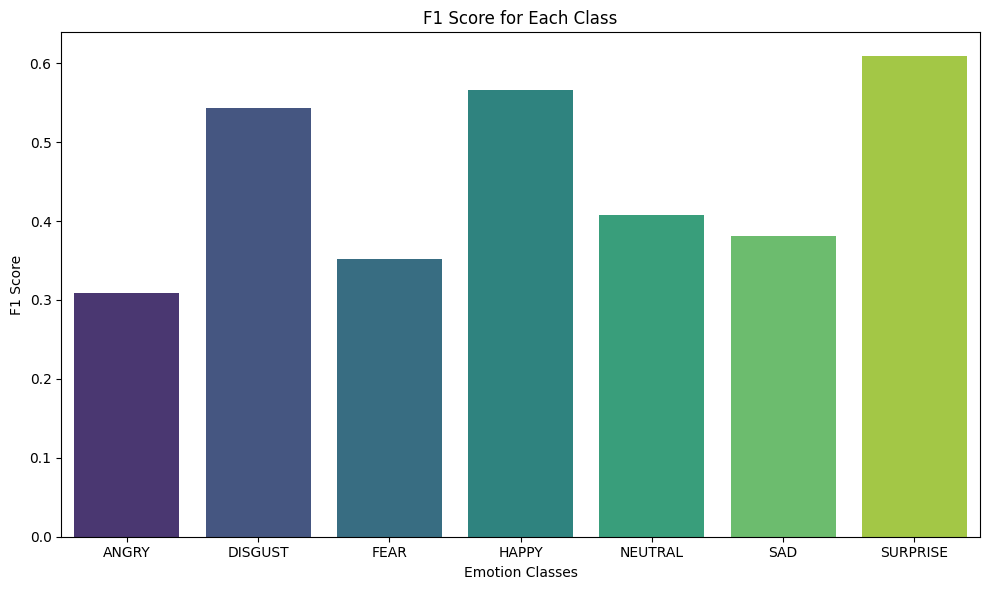

In [ ]:
fig, axes = plt.subplots(figsize=(10, 6))
sns.barplot(x=class_labels, y=df.loc[class_labels, 'f1-score'], palette='viridis', ax=axes)
axes.set_title('F1 Score for Each Class')
axes.set_xlabel('Emotion Classes')
axes.set_ylabel('F1 Score')
plt.tight_layout()
plt.show()

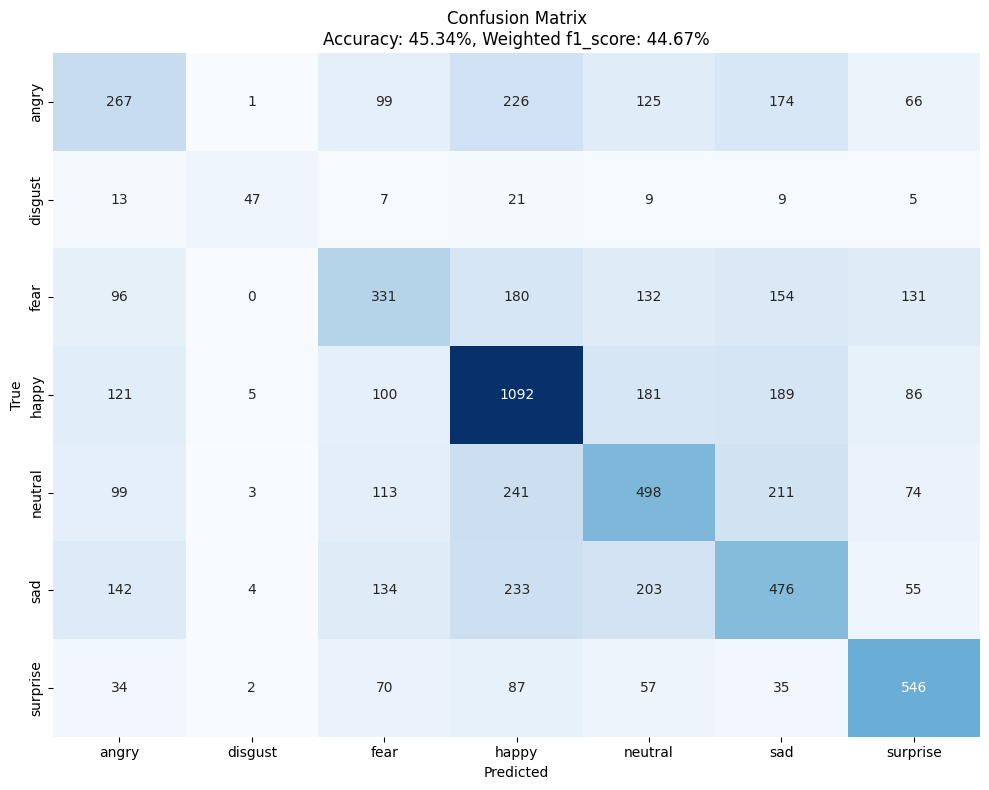

In [ ]:
cm = confusion_matrix(y_test, y_pred_test)
accuracy = accuracy_score(y_test, y_pred_test)
f1_score = f1_score(y_test, y_pred_test, average="weighted")
sns.set_palette("pastel")

plt.figure(figsize=(10, 8))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'],
            yticklabels=['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'])

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix\nAccuracy: {accuracy:.2%}, Weighted f1_score: {f1_score:.2%}')

plt.tight_layout()

plt.show()
